In [36]:
from stackrecommender import Recommender
from stacksite import StackSite
import numpy as np
import pandas as pd
import bz2
import cPickle as pkl
from pyspark import SparkContext
from pyspark.mllib.recommendation import ALS, Rating
import time, sys

In [37]:
sc = SparkContext('local[8]','pyspark')

# Normalizing 

Denote the number of stars (binned score) user $u$ actually got on their answer to question $m$ by $r_{um}$, and the predicted score by $\hat{r}_{um}$. Denote the mean stars of all answers to question $m$ by $\bar{r}_m$ and the mean stars of all answer by user $u$ by $\bar{r}_u.$ Denote the overall mean stars by $\mu.$ The model is

$$ \hat{r}_{um} = \mu + (\bar{r}_u - \mu) + (\bar{r}_m - \mu) + R_{um}, $$

where $(\bar{r}_u)$ and $(\bar{r}_m)$ are the user and question biases (resp.), and $R_{um}$ is the latent factor model.

In [2]:
with bz2.BZ2File('data/worldbuilding.stackexchange.com/fulldf.bzpkl','r') as f:
    fulldf=pkl.load(f)

In [3]:
fulldf.head()

id_pair                                           question  \
id_pair                                                               
(15, 1)  (15, 1)  How to survive mountain environments with a tr...   
(16, 3)  (16, 3)  What is the minimum human population necessary...   
(15, 3)  (15, 3)  What is the minimum human population necessary...   
(15, 8)  (15, 8)  Must magic be tied to medieval tech? Most sett...   
(19, 8)  (19, 8)  Must magic be tied to medieval tech? Most sett...   

        question_id  score  stars                               tags user_id  \
id_pair                                                                        
(15, 1)           1      9      3  [environment, altitude, mountain]      15   
(16, 3)           3     21      4          [society, colony, humans]      16   
(15, 3)           3      8      3          [society, colony, humans]      15   
(15, 8)           8      1      1                [technology, magic]      15   
(19, 8)           8      3      2                [technology, magic]      19   

         user_mean  item_mean  
id_pair                        
(15, 1)   2.375000   2.333333  
(16, 3)   2.250000   2.750000  
(15, 3)   2.375000   2.750000  
(15, 8)   2.375000   1.900000  
(19, 8)   1.590909   1.900000

In [4]:
ugroups = fulldf.groupby('user_id')
mgroups = fulldf.groupby('question_id')

In [5]:
umean = ugroups.stars.mean()
mmean = mgroups.stars.mean()

mu = fulldf.stars.mean()

In [6]:
fulldf['user_mean'] = fulldf['user_id'].apply(lambda uidx: umean.ix[uidx])
fulldf['item_mean'] = fulldf['question_id'].apply(lambda midx: mmean.ix[midx])

In [7]:
fulldf.head()

id_pair                                           question  \
id_pair                                                               
(15, 1)  (15, 1)  How to survive mountain environments with a tr...   
(16, 3)  (16, 3)  What is the minimum human population necessary...   
(15, 3)  (15, 3)  What is the minimum human population necessary...   
(15, 8)  (15, 8)  Must magic be tied to medieval tech? Most sett...   
(19, 8)  (19, 8)  Must magic be tied to medieval tech? Most sett...   

        question_id  score  stars                               tags user_id  \
id_pair                                                                        
(15, 1)           1      9      3  [environment, altitude, mountain]      15   
(16, 3)           3     21      4          [society, colony, humans]      16   
(15, 3)           3      8      3          [society, colony, humans]      15   
(15, 8)           8      1      1                [technology, magic]      15   
(19, 8)           8      3      2                [technology, magic]      19   

         user_mean  item_mean  
id_pair                        
(15, 1)   2.375000   2.333333  
(16, 3)   2.250000   2.750000  
(15, 3)   2.375000   2.750000  
(15, 8)   2.375000   1.900000  
(19, 8)   1.590909   1.900000

## Truncated SVD

In [8]:
fulldf['n_rating'] = fulldf.stars - fulldf.user_mean - fulldf.item_mean + mu

In [9]:
fulldf.head()

id_pair                                           question  \
id_pair                                                               
(15, 1)  (15, 1)  How to survive mountain environments with a tr...   
(16, 3)  (16, 3)  What is the minimum human population necessary...   
(15, 3)  (15, 3)  What is the minimum human population necessary...   
(15, 8)  (15, 8)  Must magic be tied to medieval tech? Most sett...   
(19, 8)  (19, 8)  Must magic be tied to medieval tech? Most sett...   

        question_id  score  stars                               tags user_id  \
id_pair                                                                        
(15, 1)           1      9      3  [environment, altitude, mountain]      15   
(16, 3)           3     21      4          [society, colony, humans]      16   
(15, 3)           3      8      3          [society, colony, humans]      15   
(15, 8)           8      1      1                [technology, magic]      15   
(19, 8)           8      3      2                [technology, magic]      19   

         user_mean  item_mean  n_rating  
id_pair                                  
(15, 1)   2.375000   2.333333 -0.129967  
(16, 3)   2.250000   2.750000  0.578366  
(15, 3)   2.375000   2.750000 -0.546634  
(15, 8)   2.375000   1.900000 -1.696634  
(19, 8)   1.590909   1.900000  0.087457

In [10]:
from scipy.sparse import dok_matrix

In [11]:
user_idx = pd.Series(range(len(umean)), index=umean.index)
item_idx = pd.Series(range(len(mmean)), index=mmean.index)

In [27]:
len(umean), len(mmean)

(1231, 1307)

In [120]:
R = dok_matrix((len(umean), len(mmean)))
#R = dok_matrix((max(umean.index.map(int)), max(mmean.index.map(int))))

In [121]:
def fillR(j):
    pair = fulldf.index[j]
    R[user_idx.ix[pair[0]], item_idx.ix[pair[1]]] = fulldf.n_rating.irow(j)
    #R[int(pair[0]), int(pair[1])] = fulldf.n_rating.irow(j)

In [122]:
for j in range(len(fulldf)):
    fillR(j)

In [123]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=30, n_iter=20)

In [127]:
svd.fit(R)

TruncatedSVD(algorithm='randomized', n_components=30, n_iter=20,
       random_state=None, tol=0.0)

In [133]:
def uvec(user_id):
    vec = np.zeros(len(umean))
    vec[user_idx.ix[user_id]] = 1.
    return vec

def mvec(item_id):
    vec = np.zeros(len(mmean))
    vec[item_idx.ix[item_id]] = 1.
    return vec

In [134]:
svd.transform(mvec('1'))

array([[  1.13118388e-03,   1.63877642e-03,   3.39104901e-05,
         -3.80747676e-04,   9.37253185e-04,  -9.35476779e-05,
          2.79199108e-03,  -1.02489140e-03,  -9.75615114e-04,
         -3.36329542e-03,  -7.73543366e-03,   1.18186409e-02,
         -1.01264320e-03,  -1.11286947e-03,  -2.72022503e-03,
         -1.46463534e-03,   6.99247443e-03,  -7.06866870e-03,
         -1.42386064e-02,   1.47774663e-02,   7.44277045e-03,
          2.37800881e-03,  -2.76256668e-02,  -9.72830651e-03,
         -1.01856151e-02,  -1.08054661e-03,   2.79232547e-03,
         -5.77525086e-02,  -2.68016017e-02,   4.68345776e-02]])

In [140]:
np.dot(svd.transform(mvec('1')),svd.components_[:,user_idx.ix['8']])

array([-0.0024963])

## The Recommender - Full Site

In [38]:
data = sc.parallelize(fulldf[['user_id','question_id','stars','user_mean','item_mean']].as_matrix())

In [39]:
data.first()

array([u'15', u'1', 3, 2.375, 2.3333333333333335], dtype=object)

I will use latent factors to model the normalized ratings

$$ \tilde{r}_{mu} := \hat{r}_{mu} - \mu - (\bar{r}_u - \mu) - (\bar{r}_m - \mu) = \hat{r}_{mu} - \bar{r}_u - \bar{r}_m + \mu. $$

In [40]:
normed_ratings = data.map(lambda row: Rating(int(row[0]), int(row[1]), row[2] - row[3] - row[4] + mu))

In [41]:
normed_ratings.first()

Rating(user=15, product=1, rating=-0.12996688741721862)

In [3]:
#data = sc.textFile("project/stack-exchange-recommender/data/worldbuilding.stackexchange.com/ratings.csv")
#ratings = data.map(lambda l: l.split(',')).map(lambda l: Rating(int(l[0]), int(l[1]), float(l[2])))

In [42]:
data.first(), normed_ratings.first()

(array([u'15', u'1', 3, 2.375, 2.3333333333333335], dtype=object),
 Rating(user=15, product=1, rating=-0.12996688741721862))

In [141]:
rank = 30
numIterations = 20
model = ALS.train(normed_ratings, rank, numIterations)

In [142]:
user_features = model.userFeatures().collect()
item_features = model.productFeatures().collect()

In [143]:
ufeatures = pd.DataFrame(user_features, columns = ['user_id', 'ufeatures'])
mfeatures = pd.DataFrame(item_features, columns = ['item_id', 'mfeatures'])

In [151]:
testuid = 24
testmid = 1

In [152]:
print "ALS by hand: %0.4f" % (np.dot(ufeatures[ufeatures.user_id == testuid].ufeatures.irow(0), mfeatures[mfeatures.item_id == testmid].mfeatures.irow(0)))
print "ALS: %0.4f" % (model.predict(testuid, testmid))
print "SVD: %0.4f" % (np.dot(svd.transform(mvec(str(testmid))),svd.components_[:,user_idx.ix[str(testuid)]])[0])

ALS by hand: 0.0973
ALS: 0.0973
SVD: -0.0038


In [111]:
ufeatures.head()

user_id                                          ufeatures
0        8  [-0.09669174999, -0.115885108709, -0.179137036...
1       16  [-0.045068949461, -0.143547937274, -0.06038699...
2       24  [0.0927950143814, 0.119240231812, 0.2045880854...
3       56  [-0.098222412169, -0.239249974489, -0.22276088...
4       64  [0.141021668911, -0.0922185704112, 0.156383439...

In [110]:
umeans.head()

NameError: name 'umeans' is not defined

In [45]:
testdata = ratings.map(lambda p: (p[0], p[1]))
predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))

In [73]:
predictions.first()

NameError: name 'predictions' is not defined

In [56]:
renormed_preds = predictions.map(lambda p: (p[0], p[1] + umean.ix[str(p[0][0])] + mmean.ix[str(p[0][1])] - mu))

In [57]:
renormed_preds.first()

((2884, 3984), 1.9941598812461254)

In [58]:
ratesAndPreds = ratings.map(lambda r: ((r[0], r[1]), r[2])).join(renormed_preds)
RMSE = np.sqrt(ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).reduce(lambda x, y: x+y) / ratesAndPreds.count())
print "RMSE: %.5f" % RMSE

RMSE: 0.09923


# Cross Validation of the Normalized Model 

In [3]:
rank = 10
numIterations = 20
SE, counts = np.zeros(5), np.zeros(5)

In [4]:
ranks = [2, 5, 10, 20, 30, 50, 100]
RMSE = {rank:0 for rank in ranks}
times = {rank:0 for rank in ranks}

for j in range(len(ranks)):
    start_time = time.time()
    rank = ranks[j]
    print "Rank %d: fold" % rank,
    for i in range(5):
        print i,
        sys.stdout.flush()

        train_file = "data/worldbuilding.stackexchange.com/train_ratings"+str(i)+".csv"
        test_file = "data/worldbuilding.stackexchange.com/test_ratings"+str(i)+".csv"

        train = sc.textFile(train_file).map(lambda l: l.split(',')).map(lambda r: (int(r[0]), int(r[1]), float(r[2]), float(r[3]), float(r[4])))
        test = sc.textFile(test_file).map(lambda l: l.split(',')).map(lambda r: (int(r[0]), int(r[1]), float(r[2]), float(r[3]), float(r[4])))

        mu = train.map(lambda  r: r[2]).mean()

        train_nratings = train.map(lambda r: Rating(r[0], r[1], r[2] - r[3] - r[4] + mu))
        test_ratings = test.map(lambda r: (Rating(r[0], r[1], r[2]), r[3], r[4]))

        model = ALS.train(train_nratings, rank, numIterations)

        testdata = test_ratings.map(lambda p: (p[0][0], p[0][1]))
        predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2])) 
        ratesAndPreds = test_ratings.map(lambda r: ((r[0][0],r[0][1]), (r[0][2], r[1], r[2]))).join(predictions)\
                                    .map(lambda r: (r[0], (r[1][0][0], r[1][0][1] + r[1][0][2] + r[1][1] - mu)))

        SE[i] = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).reduce(lambda x, y: x+y)
        counts[i] = ratesAndPreds.count()

    end_time = time.time()
    times[rank] = end_time-start_time
    RMSE[rank] = np.sqrt(SE.sum() / counts.sum())
    print "RMSE: %0.4f  Time: %0.2fs" % (np.sqrt(SE.sum() / counts.sum()), end_time-start_time)

Rank 2: fold 0 1 2 3 4 RMSE: 1.5790  Time: 48.06s
Rank 5: fold 0 1 2 3 4 RMSE: 1.3068  Time: 34.38s
Rank 10: fold 0 1 2 3 4 RMSE: 1.1682  Time: 34.22s
Rank 20: fold 0 1 2 3 4 RMSE: 1.1306  Time: 32.86s
Rank 30: fold 0 1 2 3 4 RMSE: 1.1216  Time: 34.38s
Rank 50: fold 0 1 2 3 4 RMSE: 1.1198  Time: 40.41s
Rank 100: fold 0 1 2 3 4 RMSE: 1.1192  Time: 63.00s


### Timing results.

*Laptop*

    Rank 2: fold 0 1 2 3 4 RMSE: 1.5926  Time: 13.88s
    Rank 5: fold 0 1 2 3 4 RMSE: 1.3135  Time: 16.12s
    Rank 10: fold 0 1 2 3 4 RMSE: 1.1641  Time: 18.90s
    Rank 20: fold 0 1 2 3 4 RMSE: 1.1275  Time: 22.44s
    Rank 30: fold 0 1 2 3 4 RMSE: 1.1242  Time: 21.43s
    Rank 50: fold 0 1 2 3 4 RMSE: 1.1212  Time: 31.47s
    Rank 100: fold 0 1 2 3 4 RMSE: 1.1210  Time: 87.43s

*DigitalOcean*

    Rank 2: fold 0 1 2 3 4 RMSE: 1.5790  Time: 48.06s
    Rank 5: fold 0 1 2 3 4 RMSE: 1.3068  Time: 34.38s
    Rank 10: fold 0 1 2 3 4 RMSE: 1.1682  Time: 34.22s
    Rank 20: fold 0 1 2 3 4 RMSE: 1.1306  Time: 32.86s
    Rank 30: fold 0 1 2 3 4 RMSE: 1.1216  Time: 34.38s
    Rank 50: fold 0 1 2 3 4 RMSE: 1.1198  Time: 40.41s
    Rank 100: fold 0 1 2 3 4 RMSE: 1.1192  Time: 63.00s

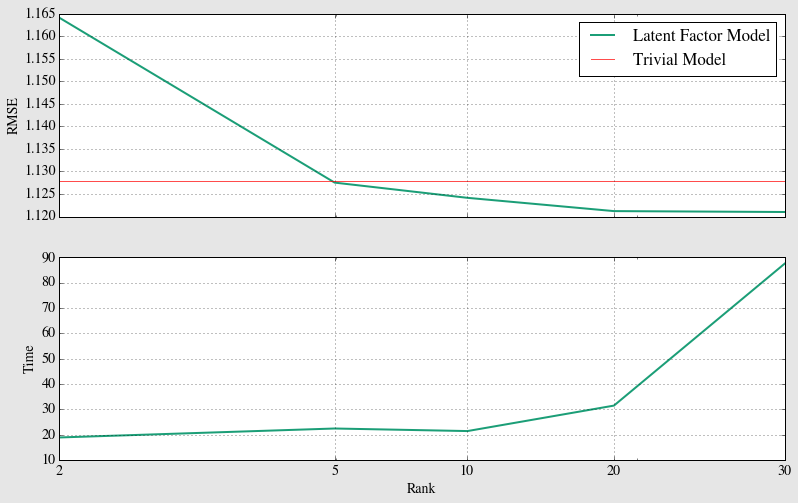

In [379]:
rs = [10, 20, 30, 50, 100]
x = [np.log(r) for r in rs]
y1 = [RMSE[rank] for rank in rs]
y2 = [times[rank] for rank in rs]
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(13,8))
ax1.plot(x, y1, label = "Latent Factor Model")
ax1.set_ylabel('RMSE')
ax1.set_xscale('log')
ax1.set_xlim(np.log(10),np.log(100))
ax1.axhline(1.12796, color = "red", alpha = 0.7, lw = 1, label = "Trivial Model")
ax1.legend(loc='upper right')
ax1.grid(True)

ax2.plot(x, y2)
ax2.set_xlabel('Rank')
ax2.set_ylabel('Time')
ax2.set_xscale('log')
ax2.grid(True)
ax2.set_xticks(np.log(rs))
ax2.set_xticklabels(ranks)

#plt.savefig('LF-model.pdf', bbox_inches='tight')

## Modeling the Residuals with a Collaborative Filter

Now that I have a latent factor model, I want to use a collaborative filter to model the residuals. As above, $\hat{r}_{um}$ denotes the latent-factor prediction for the rating of user $u$ on question $m$. I want to make similarity corrections to this prediction. 

Let $s_{mn}$ denote the LDA similarity between questions $m$ and $n$. Let $\mathcal{S}_k(u,m)$ denote the $k$-nearest neighborhood of question $m$ among questions answered by user $u$. The refined model prediction will be denoted by $\tilde{r}_{um}$ and computed by

$$ \tilde{r}_{um} = \hat{r}_{um} + \frac{\sum_{n\in\mathcal{S}_k(m,u)} s_{mn} (r_{un} - \hat{r}_{un})}{\sum_{n\in\mathcal{S}_k(m,u)} s_{mn}}. $$

I'll use the 20-factor model. The model will be built on the last fold of the training data `train_dfs[4]` and then tested on `test_fds[4]`.

In [11]:
%%time
rank = 40
numIterations = 35
i = 2

train_file = "data/worldbuilding.stackexchange.com/train_ratings"+str(i)+".csv"
test_file = "data/worldbuilding.stackexchange.com/test_ratings"+str(i)+".csv"

train = sc.textFile(train_file).map(lambda l: l.split(',')).map(lambda r: (int(r[0]), int(r[1]), float(r[2]), float(r[3]), float(r[4])))
test = sc.textFile(test_file).map(lambda l: l.split(',')).map(lambda r: (int(r[0]), int(r[1]), float(r[2]), float(r[3]), float(r[4])))

mu = train.map(lambda  r: r[2]).mean()

train_normed_ratings = train.map(lambda r: Rating(r[0], r[1], r[2] - r[3] - r[4] + mu))
train_ratings = train.map(lambda r: (Rating(r[0], r[1], r[2]), r[3], r[4]))

# predict on the test set
test_ratings = test.map(lambda r: (Rating(r[0], r[1], r[2]), r[3], r[4]))

model = ALS.train(train_normed_ratings, rank, numIterations)

# we also need run the model on the training data for later use
traindata = train_normed_ratings.map(lambda p: (p[0], p[1]))
testdata = test_ratings.map(lambda p: (p[0][0], p[0][1]))

train_predictions = model.predictAll(traindata).map(lambda r: ((r[0], r[1]), r[2])) 
test_predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))

train_ratesPreds = train_ratings.map(lambda r: ((r[0][0],r[0][1]), (r[0][2], r[1], r[2]))).join(train_predictions)\
                            .map(lambda r: (r[0], (r[1][0][0], r[1][0][1] + r[1][0][2] + r[1][1] - mu), r[1][0][1], r[1][0][2]))
test_ratesPreds = test_ratings.map(lambda r: ((r[0][0],r[0][1]), (r[0][2], r[1], r[2]))).join(test_predictions)\
                            .map(lambda r: (r[0], (r[1][0][0], r[1][0][1] + r[1][0][2] + r[1][1] - mu)))

CPU times: user 102 ms, sys: 7.68 ms, total: 109 ms
Wall time: 4.4 s


In [12]:
traindf = pd.DataFrame(train_ratesPreds.map(lambda r: (r[0][0], r[0][1], r[1][0], r[1][1], r[2], r[3])).collect(), 
                               columns = ['user_id', 'question_id', 'stars', 'LF', 'user_mean', 'item_mean'])
traindf['id_pair'] = zip(traindf.user_id, traindf.question_id)
traindf = traindf.set_index(traindf.id_pair, drop=True)
traindf.head()

user_id  question_id  stars        LF  user_mean  item_mean  \
id_pair                                                                     
(736, 3936)       736         3936      3  3.000437   2.833333   1.800000   
(4857, 7233)     4857         7233      1  1.001179   1.794118   1.000000   
(401, 11241)      401        11241      1  1.011579   1.750000   1.333333   
(3434, 8906)     3434         8906      2  1.979373   1.571429   1.166667   
(3202, 9826)     3202         9826      2  2.001718   2.181818   1.500000   

                   id_pair  
id_pair                     
(736, 3936)    (736, 3936)  
(4857, 7233)  (4857, 7233)  
(401, 11241)  (401, 11241)  
(3434, 8906)  (3434, 8906)  
(3202, 9826)  (3202, 9826)

In [13]:
umeans = traindf.groupby('user_id').user_mean.mean()
mmeans = traindf.groupby('question_id').item_mean.mean()
mset = set(mmeans.index)
uset = set(umeans.index)

def safe_u(uidx):
    if int(uidx) in uset:
        return umeans.ix[int(uidx)]
    else:
        return None
    
def safe_m(midx):
    if int(midx) in mset:
        return mmeans.ix[int(midx)]
    else:
        return None

In [14]:
testdf = pd.DataFrame(test_ratesPreds.map(lambda r: (r[0][0], r[0][1], r[1][0], r[1][1])).collect(), 
                               columns = ['user_id', 'question_id', 'stars', 'LF'])
testdf.user_id = testdf.user_id.apply(str)
testdf['id_pair'] = zip(testdf.user_id, testdf.question_id)
testdf = testdf.set_index(testdf.id_pair, drop=True)
testdf['user_mean'] = testdf.user_id.apply(safe_u)
testdf['item_mean'] = testdf.question_id.apply(safe_m)
testdf = testdf.dropna()
testdf.head(10)

user_id  question_id  stars        LF       id_pair  user_mean  \
id_pair                                                                       
(7, 10243)         7        10243      3  1.478266    (7, 10243)   2.102564   
(6427, 8601)    6427         8601      0 -0.586282  (6427, 8601)   0.000000   
(687, 9529)      687         9529      1  0.320052   (687, 9529)   1.142857   
(3112, 8746)    3112         8746      3  1.639161  (3112, 8746)   1.343750   
(7325, 4679)    7325         4679      0  2.007176  (7325, 4679)   2.000000   
(6861, 9789)    6861         9789      0  0.234692  (6861, 9789)   0.800000   
(49, 4567)        49         4567      4  1.841940    (49, 4567)   2.191617   
(288, 3646)      288         3646      1  1.961653   (288, 3646)   1.616162   
(147, 10891)     147        10891      1  0.942874  (147, 10891)   1.527273   
(3278, 5078)    3278         5078      2  1.392902  (3278, 5078)   1.480000   

              item_mean  
id_pair                  
(7, 10243)     1.500000  
(6427, 8601)   1.000000  
(687, 9529)    1.062500  
(3112, 8746)   2.000000  
(7325, 4679)   1.555556  
(6861, 9789)   1.000000  
(49, 4567)     1.333333  
(288, 3646)    1.636364  
(147, 10891)   1.000000  
(3278, 5078)   1.250000

In [15]:
np.sqrt(((testdf.LF - testdf.stars)**2).sum() / len(testdf))

1.1067570086539986

In [16]:
site_name = 'worldbuilding.stackexchange.com'
site = StackSite(site_name)
site.load()
df_dict = site.df_dict()
#df_dict = site.generate_dfs()

Dataframes successfully loaded.


In [17]:
rc = Recommender(site_name, df_dict = df_dict)
#rc.train(df_dict = df_dict, multicore=True)
rc.load('full')

Loading the model...
 ...LDA model loaded.
 ...question LDA vectors loaded.
Successfully loaded the recommender.


In [18]:
rc.compute_sim()

In [19]:
train_file

'data/worldbuilding.stackexchange.com/train_ratings2.csv'

In [48]:
ugroups = traindf.groupby('user_id')
uset = set(traindf.user_id.unique().tolist())
qset = set(traindf.question_id.unique().tolist())

def CFmodel(uid, qid):
    
    #print uid, qid
    #sys.stdout.flush()
    
    if (int(uid) not in uset) or (int(qid) not in qset):
        return None
    
    # get the questions answered by the user
    uqdf = ugroups.get_group(int(uid)).copy()
    uqdf.set_index(uqdf.question_id)

    # get the similarities and LF scores 
    sims = dict(zip(uqdf.question_id.apply(int), 
               np.atleast_1d(rc.question_similarity[rc.question_idx[str(qid)], 
                                      rc.question_idx[uqdf.question_id.apply(str)]])))

    lfs = dict(zip(uqdf.question_id.apply(int),uqdf.LF))

    stars = dict(zip(uqdf.question_id.apply(int), uqdf.stars))

    # parallelize the list for the model
    uqs = sc.parallelize(zip(uqdf.user_id, uqdf.question_id.apply(int)))

    # make the LF predictions
    ups = dict(model.predictAll(uqs).map(lambda r: (r[1], r[2])).collect())

    # compute the results
    lf_score = model.predict(int(uid), int(qid)) + uqdf.user_mean.irow(0) + traindf[traindf.question_id == int(qid)].item_mean.irow(0) - mu
    cf_num = np.sum([sims[qid] * (stars[qid] - lfs[qid]) for qid in uqdf.question_id.apply(int)])
    cf_den = np.sum(sims.values())

    return (lf_score, cf_num, cf_den)

In [50]:
from scipy.stats.stats import pearsonr 
pearsonr(np.ravel(rc.question_similarity), np.ravel(rc.tag_similarity))

(0.15668785039113428, 0.0)

In [42]:
j = 1
testuid = testdf.user_id.irow(j)
testqid = str(testdf.question_id.irow(j))
testqid2 = str(testdf.question_id.irow(j+3))
testuid, testqid, CFmodel(testuid, testqid), testdf.stars.irow(j), testdf.LF.irow(j)

('6427',
 '8601',
 (-0.5862819712002687, -1.5189581117071956e-06, 0.0092908900375234943),
 0.0,
 -0.5862819712002687)

In [43]:
model.predict(int(testuid), int(testqid))

-8.221684952430374e-06

In [44]:
%%time
testdf['CF_model'] = testdf.id_pair.apply(lambda p: CFmodel(p[0],p[1]))

CPU times: user 19.7 s, sys: 1.62 s, total: 21.3 s
Wall time: 5min 23s


In [46]:
def makescore(a):
    lf = a[0]
    num = a[1]
    den = a[2]
    if den == 0:
        return lf
    else:
        return (lf+num/den)
testdf['CF_pred'] = testdf.CF_model.apply(makescore)

In [51]:
np.sqrt(((testdf.dropna().CF_pred - testdf.dropna().stars)**2).sum() / len(testdf.dropna()))

1.1118917534804187

####Similarity Wars 

Tag similarity: `1.1115617549874264`

In [52]:
testdf.head()

user_id  question_id  stars        LF       id_pair  user_mean  \
id_pair                                                                       
(7, 10243)         7        10243      3  1.478266    (7, 10243)   2.102564   
(6427, 8601)    6427         8601      0 -0.586282  (6427, 8601)   0.000000   
(687, 9529)      687         9529      1  0.320052   (687, 9529)   1.142857   
(3112, 8746)    3112         8746      3  1.639161  (3112, 8746)   1.343750   
(7325, 4679)    7325         4679      0  2.007176  (7325, 4679)   2.000000   

              item_mean                                           CF_model  \
id_pair                                                                      
(7, 10243)     1.500000  (1.47826582896, -0.00264244814147, 3.46419582754)   
(6427, 8601)   1.000000  (-0.5862819712, -1.51895811171e-06, 0.00929089...   
(687, 9529)    1.062500   (0.320052371968, -0.181485295563, 12.9608994476)   
(3112, 8746)   2.000000   (1.63916115427, -0.0371285588826, 5.33397820652)   
(7325, 4679)   1.555556  (2.00717564613, -0.00777692696696, 0.523148966...   

               CF_pred       CF_corr  
id_pair                               
(7, 10243)    1.477503 -9.263190e-03  
(6427, 8601) -0.586445 -1.634890e-04  
(687, 9529)   0.306050  1.183400e-02  
(3112, 8746)  1.632200 -2.126333e-01  
(7325, 4679)  1.992310  4.440892e-16

In [53]:
np.sqrt(((testdf.dropna().LF - testdf.dropna().stars)**2).sum() / len(testdf.dropna()))

1.1067570086539986

Maybe I need to scale my corrections... they could be generally in the right direction by much to large.

In [54]:
testdf.head()

user_id  question_id  stars        LF       id_pair  user_mean  \
id_pair                                                                       
(7, 10243)         7        10243      3  1.478266    (7, 10243)   2.102564   
(6427, 8601)    6427         8601      0 -0.586282  (6427, 8601)   0.000000   
(687, 9529)      687         9529      1  0.320052   (687, 9529)   1.142857   
(3112, 8746)    3112         8746      3  1.639161  (3112, 8746)   1.343750   
(7325, 4679)    7325         4679      0  2.007176  (7325, 4679)   2.000000   

              item_mean                                           CF_model  \
id_pair                                                                      
(7, 10243)     1.500000  (1.47826582896, -0.00264244814147, 3.46419582754)   
(6427, 8601)   1.000000  (-0.5862819712, -1.51895811171e-06, 0.00929089...   
(687, 9529)    1.062500   (0.320052371968, -0.181485295563, 12.9608994476)   
(3112, 8746)   2.000000   (1.63916115427, -0.0371285588826, 5.33397820652)   
(7325, 4679)   1.555556  (2.00717564613, -0.00777692696696, 0.523148966...   

               CF_pred       CF_corr  
id_pair                               
(7, 10243)    1.477503 -9.263190e-03  
(6427, 8601) -0.586445 -1.634890e-04  
(687, 9529)   0.306050  1.183400e-02  
(3112, 8746)  1.632200 -2.126333e-01  
(7325, 4679)  1.992310  4.440892e-16

In [55]:
testdf['CF_corr'] = testdf.CF_pred - testdf.LF

In [56]:
LFsgn = testdf.LF.copy() / np.abs(testdf.LF)
deltasgn = testdf.CF_corr.copy() / np.abs(testdf.CF_corr)

In [57]:
len(testdf.LF[(LFsgn + deltasgn) == 0])

462

In [58]:
len(testdf.LF)

970

In [59]:
alpha = np.linspace(-1,1,100)
rmse = np.zeros(len(alpha))
for j in range(len(alpha)):
    rmse[j] = np.sqrt(((testdf.LF+alpha[j] * testdf.CF_corr-testdf.stars)**2).sum() / len(testdf))

([<matplotlib.axis.XTick at 0x7f55a0a85dd0>,
 <a list of 5 Text xticklabel objects>)

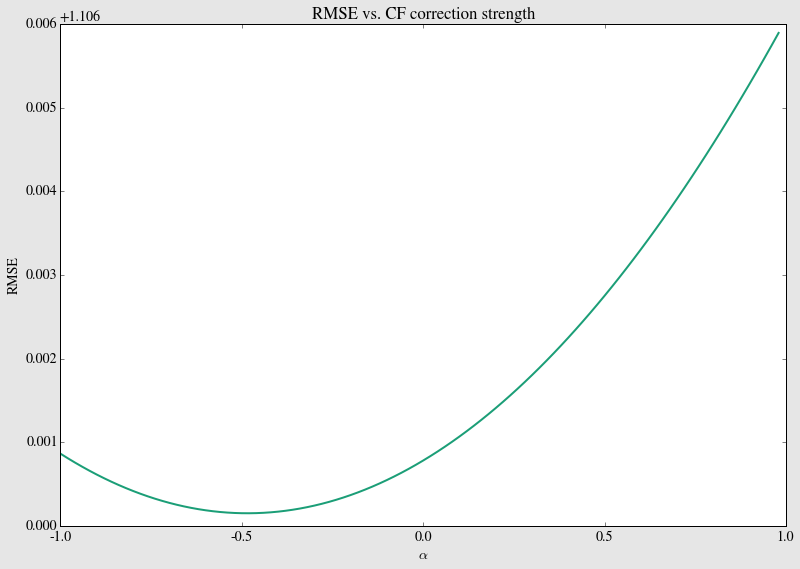

In [60]:
plt.figure(figsize=(13,9))
plt.plot(rmse)
plt.title("RMSE vs. CF correction strength")
plt.xlabel(r'$\alpha$')
plt.ylabel('RMSE')
plt.xticks(np.linspace(0,100,5), np.linspace(-1,1,5))

In [40]:
np.argmin(rmse)

8

# Nondiagonal tag similarity 

In [ ]:
tagX = np.zeros((len(rc.tags_df), len(rc.tags_df)))
for tag in rc.tags_df.name:
    for j in range(len(rc.questions_df)):
        if questions_df

I will declare that the similarity of `tag1` and `tag2` is proportional to the number of questions on which they simultaneously appear. At the end, I'll normalize by the maximum value, so that all similarities are between `0` an `1`.

#### Scratch

In [281]:
ugroups.get_group(testuid).user_mean.irow(0) + traindf[traindf.question_id == testqid].item_mean.irow(0) - mu

3.6084285151634505

In [238]:
testdf_temp = pd.read_table(test_file, sep=',', header=None, index_col=None)
testdf_temp.columns = ['user_id','question_id','stars','user_mean','item_mean']
testdf_temp['id_pair'] = zip(testdf_temp.user_id.apply(str), testdf_temp.question_id.apply(str))

In [240]:
testdf = testdf.merge(testdf_temp[['id_pair','user_mean','item_mean']], left_on='id_pair', right_on='id_pair')

In [243]:
testdf['full_CF'] = testdf.CF + testdf.user_mean + testdf.item_mean - mu

In [241]:
testdf.head()

user_id  question_id  stars    id_pair        CF  user_mean  item_mean
0        6         1287      1  (6, 1287)  0.066302   1.000000          1
1        6         1412      1  (6, 1412) -0.224181   1.000000          1
2        7          546      2   (7, 546) -0.082256   1.909091          2
3        7          625      1   (7, 625)  0.152836   1.909091          1
4        7         1086      1  (7, 1086) -0.146347   1.909091          1

In [248]:
np.sqrt(((testdf.dropna().stars - testdf.dropna().full_CF)**2 ).sum() / len(testdf.dropna()))

0.78190715510190978

In [259]:
testdf.LF = testdf.LF + testdf.user_mean + testdf.item_mean - mu

In [251]:
model.predict(6,1287)

0.03723765130829819

In [257]:
def safe_model(a):
    if int(a[0]) in uset and str(a[1]) in qset:
        return model.predict(a[0], a[1])
    else: return None
    
testdf['LF'] = testdf.id_pair.apply(safe_model) + testdf.user_mean + testdf.item_mean - mu

In [260]:
np.sqrt(((testdf.dropna().stars - testdf.dropna().LF)**2 ).sum() / len(testdf.dropna()))

0.74550966776939243

In [310]:
# get the questions answered by the user
uqdf = ugroups.get_group(int(testuid)).copy()
uqdf.set_index(uqdf.question_id)

# get the similarities and LF scores 
sims = dict(zip(uqdf.question_id.apply(int), 
           np.atleast_1d(rc.question_similarity[rc.question_idx[str(testqid)], 
                                  rc.question_idx[uqdf.question_id.apply(str)]])))

lfs = dict(zip(uqdf.question_id.apply(int),uqdf.LF))

stars = dict(zip(uqdf.question_id.apply(int), uqdf.stars))

# parallelize the list for the model
uqs = sc.parallelize(zip(uqdf.user_id, uqdf.question_id.apply(int)))

# make the LF predictions
ups = dict(model.predictAll(uqs).map(lambda r: (r[1], r[2])).collect())

# compute the results
lf_score = model.predict(int(testuid), int(testqid)) + uqdf.user_mean.irow(0) + traindf[traindf.question_id == testqid].item_mean.irow(0) - mu
cf_num = np.sum([sims[qid] * (stars[qid] - lfs[qid]) for qid in uqdf.question_id.apply(int)])
cf_den = np.sum(sims.values())

(lf_score + cf_num / cf_den)

2.4473205070012654

In [197]:
sc.union([ups, sims]).reduceByKey(lambda a, b: a*b).map(lambda r: r[1]).reduce(lambda a, b: a+b)

-0.72794697128208408

In [200]:
sims.map(lambda r: r[1]).reduce(lambda a, b: a+b)

1.2645286057803038

In [184]:
ups.collect()

[(3936, -0.607540837563794),
 (3953, -0.4034105070121762),
 (3601, 0.0916339144771324),
 (3939, -1.0420627605703354)]

In [221]:
ugroups.get_group(24)

LF     id_pair  user_id question_id  stars  user_mean  item_mean
419  1.00226  (24, 3294)       24        3294      1          1   1.666667

In [201]:
# get the questions answered by the user
uqdf = ugroups.get_group(int(testuid)).copy()

# get the similarities
sims = sc.parallelize(zip(uqdf.question_id.apply(int), 
           rc.question_similarity[rc.question_idx[str(testqid)], rc.question_idx[uqdf.question_id.apply(str)]]))

# parallelize the list for the model
uqs = sc.parallelize(zip(uqdf.user_id, uqdf.question_id.apply(int)))

# make the LF predictions
ups = model.predictAll(uqs).map(lambda r: (r[1], r[2]))

# compute the results
sc.union([ups,sims]).reduceByKey(lambda a, b: a*b).map(lambda r: r[1]).reduce(lambda a, b: a+b) / sims.map(lambda r: r[1]).reduce(lambda a, b: a+b)

-0.57566666974124259

In [58]:
rc.question_similarity[rc.question_idx['3936'], rc.question_idx[traindf.question_id]]

array([ 1.        ,  0.14071687,  0.02961038, ...,  0.04046585,
        0.02731339,  0.00461998])

In [65]:
def kNN(qid, df, k = 7):
    
    sims = pd.DataFrame(rc.question_similarity[rc.question_idx[qid], rc.question_idx[df.question_id]],
                        index=df.question_id, columns=['similarity'])
    sims.sort(ascending=False)
    k = min(k, len(df))
    
    return sims.head(k)

In [78]:
testuid = rc.answers_df.user_id.irow(17)
testuid
model.predict(testuid, '3936')

-0.18071254176829632

In [80]:
ugroups = traindf.groupby('user_id')

In [87]:
uqdf = ugroups.get_group(int(testuid)).copy()

In [91]:
uqs = sc.parallelize(zip(uqdf.user_id, uqdf.question_id.apply(int)))

In [93]:
ups = model.predictAll(uqs)

In [102]:
ups = pd.DataFrame(model.predictAll(uqs).map(lambda r: (r[1], r[2])).collect(), columns=['question_id', 'LF'])

In [164]:
uqs.collect()

[(35, 46),
 (35, 890),
 (35, 10),
 (35, 484),
 (35, 2884),
 (35, 3188),
 (35, 332),
 (35, 10159)]

In [162]:
model.predictAll(uqs).collect()

[Rating(user=35, product=332, rating=-0.03355747237015822),
 Rating(user=35, product=2884, rating=0.12640010492519665),
 Rating(user=35, product=3188, rating=0.06532777871449935),
 Rating(user=35, product=484, rating=0.9522324166913928),
 Rating(user=35, product=890, rating=0.45514143517506106),
 Rating(user=35, product=46, rating=0.6349179819834865),
 Rating(user=35, product=10, rating=-0.28414661424182236),
 Rating(user=35, product=10159, rating=-0.5097495155473506)]

In [108]:
rc.question_idx[ups.question_id.apply(str)]

question_id
332              73
2884            335
3188            388
484             110
890             172
46               17
10                5
10159          1086
dtype: int64

In [110]:
ups['sim'] = rc.question_similarity[rc.question_idx['3936'], rc.question_idx[ups.question_id.apply(str)]]

In [113]:
ups

question_id        LF       sim
0          332 -0.033557  0.000000
1         2884  0.126400  0.364403
2         3188  0.065328  0.300497
3          484  0.952232  0.000000
4          890  0.455141  0.099517
5           46  0.634918  0.048043
6           10 -0.284147  0.030435
7        10159 -0.509750  0.479498

In [117]:
model.predict(testuid, 3936), model.predict(testuid, 3936) + (ups.LF * ups.sim).sum() / ups.sim.sum()

(-0.18071254176829632, -0.26509202230189782)

In [124]:
CFmodel(rc.answers_df.user_id.irow(24), '2884')

-0.49515344884691692

In [26]:
rc.answers_df.head()

user_id parent_id  score  \
post_id                            
4            15         1      9   
6            16         3     21   
7            15         3      8   
11           15         8      1   
12           19         8      3   

                                                    answer  stars  
post_id                                                            
4        The human body would adapt and deal with eleva...      3  
6        This is quite dependent on technological/medic...      4  
7        This is known as the Minimum Viable Population...      3  
11       Not at all, D&D 3.5 released Eberron, which ha...      1  
12       There are plenty of novels with magic and magi...      2

In [86]:
test_df = pd.read_table(test_file, sep=',', header=None, index_col=None)
test_df.columns = ['user_id','question_id','stars','user_mean','item_mean']
test_df['id_pair'] = zip(test_df.user_id, test_df.question_id)
test_df.head(11)

user_id  question_id  stars  user_mean  item_mean    id_pair
0         6         1287      1   1.000000        1.0  (6, 1287)
1         6         1412      1   1.000000        1.0  (6, 1412)
2         7          546      2   1.909091        2.0   (7, 546)
3         7          625      1   1.909091        1.0   (7, 625)
4         7         1086      1   1.909091        1.0  (7, 1086)
5         7         3953      3   1.909091        1.5  (7, 3953)
6         7         4850      3   1.909091        3.0  (7, 4850)
7         7         5124      1   1.909091        1.5  (7, 5124)
8         7         9094      2   1.909091        2.0  (7, 9094)
9         7         9437      2   1.909091        2.0  (7, 9437)
10        7         9847      2   1.909091        2.0  (7, 9847)

In [62]:
ugroups = train_df.groupby('user_id')

In [115]:
preddf.user_id = preddf.user_id.apply(int)
preddf.question_id = preddf.question_id.apply(int)
preddf.id_pair = zip(preddf.user_id, preddf.question_id)
preddf.head()

user_id  question_id  stars  predicted      id_pair
id_pair                                                         
(7, 10243)         7        10243      3   3.024999   (7, 10243)
(349, 1213)      349         1213      3   3.732384  (349, 1213)
(687, 9529)      687         9529      1   0.421537  (687, 9529)
(49, 4729)        49         4729      3   3.392071   (49, 4729)
(115, 4757)      115         4757      1   1.555498  (115, 4757)

In [122]:
test_df = test_df.merge(preddf[['predicted']], how='inner', left_on='id_pair', right_index=True)
test_df.head()

user_id  question_id  stars  user_mean  item_mean    id_pair  predicted
0        6         1287      1   1.000000          1  (6, 1287)   0.409447
1        6         1412      1   1.000000          1  (6, 1412)   0.430824
2        7          546      2   1.909091          2   (7, 546)   2.289532
3        7          625      1   1.909091          1   (7, 625)   1.609747
4        7         1086      1   1.909091          1  (7, 1086)   1.272931

In [139]:
ugroups = train_df.groupby('user_id')

In [146]:
rc.question_idx.ix[ugroups.get_group(6).question_id.apply(str)]

post_id
2            1
5            3
8            4
42          15
157         44
325         72
1283       228
1402       253
2503       270
dtype: int64

In [133]:
test_df.question_id = test_df.question_id.apply(str)

In [148]:
zip(ugroups.get_group(6).question_id.apply(str),
    rc.question_similarity[rc.question_idx.ix['1287'],rc.question_idx.ix[ugroups.get_group(6).question_id.apply(str)]])

[('2', 0.0),
 ('5', 0.0),
 ('8', 0.022467184625758703),
 ('42', 0.0),
 ('157', 0.057194798988512235),
 ('325', 0.07092491537759639),
 ('1283', 0.05082938420798614),
 ('1402', 0.14470524733025275),
 ('2503', 0.69809812499771429)]

In [131]:
rc.question_similarity[1287, ugroups.get_group(6).question_id]

IndexError: index 1412 is out of bounds for axis 1 with size 1321

## Cross-Validation of the Nonnormalized Model

In [36]:
rank = 50
numIterations = 40
SE, counts = np.zeros(5), np.zeros(5)

In [37]:
print "Fold",
for i in range(5):
    print i,
    sys.stdout.flush()
    
    train_file = "project/stack-exchange-recommender/data/worldbuilding.stackexchange.com/train_ratings"+str(i)+".csv"
    test_file = "project/stack-exchange-recommender/data/worldbuilding.stackexchange.com/test_ratings"+str(i)+".csv"
    
    train = sc.textFile(train_file)
    test = sc.textFile(test_file)
    
    train_ratings = train.map(lambda l: l.split(',')).map(lambda l: Rating(int(l[0]), int(l[1]), float(l[2])))
    test_ratings = test.map(lambda l: l.split(',')).map(lambda l: Rating(int(l[0]), int(l[1]), float(l[2])))
    
    model = ALS.train(train_ratings, rank, numIterations)
    
    testdata = test_ratings.map(lambda p: (p[0], p[1]))
    predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))    
    ratesAndPreds = test_ratings.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
    
    SE[i] = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).reduce(lambda x, y: x+y)
    counts[i] = ratesAndPreds.count()
    
print "\nRMSE: ", np.sqrt(SE.sum() / counts.sum())

Fold 0 1 2 3 4 
RMSE:  1.3490170798


In [16]:
train.first(), test.first(), train_ratings.first(), test_ratings.first()

(u'3,94,3.0',
 u'6,2,3.0',
 Rating(user=3, product=94, rating=3.0),
 Rating(user=6, product=2, rating=3.0))

In [24]:
rank = 20
numIterations = 40
model = ALS.train(train_ratings, rank, numIterations)

In [25]:
testdata = test_ratings.map(lambda p: (p[0], p[1]))
predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))

In [26]:
ratesAndPreds = test_ratings.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
RMSE = np.sqrt(ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).reduce(lambda x, y: x+y) / ratesAndPreds.count())
print "RMSE: %.5f" % RMSE

RMSE: 1.42403


In [12]:
sc.stop()